In [1]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline


In [2]:
def generate_matrix(type: str, sparse: bool, size: int, min_val: float, max_val: float, grouping_factor: float = 0, density: float = 1) -> np.array:
  """Generates various types of REAL matrices with controlled value range and diagonal grouping.

  Args:
    type: The type of matrix to generate.
          Options: 'nonsymmetric', 'symmetric', 'normal', 'orthogonal'.
    sparse: Whether to generate a sparse matrix.
    size: The size of the matrix (size x size).
    min_val: Minimum value of the matrix elements.
    max_val: Maximum value of the matrix elements.
    grouping_factor: Controls the strength of diagonal grouping. 
                     0: No grouping.
                     Positive values: Increase grouping strength.

  Returns:
    A NumPy array representing the generated matrix.
  """
  
  seed = 42
  np.random.seed(seed)
  
  if type == 'nonsymmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr').toarray()
    else:
      A = np.random.rand(size, size)
    if grouping_factor > 0:
      for i in range(size):
        A[i, :] = A[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
    return A * (max_val - min_val) + min_val

  elif type == 'symmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr')
      A = (A + A.transpose()).toarray() / 2
    else:
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
    if grouping_factor > 0:
      for i in range(size):
        for j in range(size):
          A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
    return A * (max_val - min_val) + min_val

  elif type == 'normal':
    if sparse:
      raise ValueError("Sparse normal matrices are not well-defined.")
    else:
      # Generate a symmetric matrix (guaranteed to be normal)
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
      if grouping_factor > 0:
        for i in range(size):
          for j in range(size):
            A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
      return A * (max_val - min_val) + min_val

  elif type == 'orthogonal':
    if sparse:
      raise ValueError("Sparse orthogonal matrices are not well-defined.")
    else:
      Q, _ = np.linalg.qr(np.random.rand(size, size))
      if grouping_factor > 0:
        for i in range(size):
          Q[i, :] = Q[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
      return Q * (max_val - min_val) + min_val

  else:
    raise ValueError(f"Invalid matrix type: {type}")

In [3]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [4]:
def testing(my_function, A: np.array, name: str,show_plots: bool=False, function_name: str="My_func"):
  """Compares your eigenvalue algorithm with NumPy's eigvals.

  Args:
    my_function: function that takes a NumPy array (matrix) and returns a NumPy array of eigenvalues.
    A: The input matrix for eigenvalue calculation.
  """


  start_time = time.time()
  my_eigenvalues = my_function(A).copy()
  my_time = time.time() - start_time

  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time

  my_eigenvalues.sort()
  numpy_eigenvalues.sort()

  # Accuracy
  
  errors = np.abs(numpy_eigenvalues - my_eigenvalues) / np.abs(numpy_eigenvalues)
  max_error = np.max(errors)
  avg_error = np.mean(errors)
  median_error = np.median(errors)
  print("----------")
  print(f'{name}:')
  print("  Time:", my_time, "seconds")
  print("NumPy eigvals:")
  print("  Time:", numpy_time, "seconds")
  print("\nAccuracy:")
  print("  Maximum Error:", max_error)
  print("  Average Error:", avg_error)
  print("  Median Error:", median_error)
  print("----------\n")
  if(show_plots):
    # Plot the differences
    my_eigenvalues_abs = np.abs(my_eigenvalues)
    numpy_eigenvalues_abs = np.abs(numpy_eigenvalues)
    plt.figure(figsize=(8, 6))
    plt.plot(my_eigenvalues_abs, label=str(function_name + ' abs'))
    plt.plot(numpy_eigenvalues_abs, label="NumPy eigvals abs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    # Plot the errors
    plt.figure(figsize=(8, 6))
    plt.plot(errors)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Absolute Error")
    plt.title("Eigenvalue Error $ \dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")
    plt.show()


<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_41684/3535834220.py:55: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Eigenvalue Error $ \dfrac{\mid\lambda_{n} - \lambda_{f}\mid}{\mid\lambda_{n}\mid}$")


In [5]:
def test_all(matrix_dict: dict, my_function,show_plots: bool=False,skip_matrices_id: list=[], function_name: str="some function"):
    for matrix_id,items in matrix_dict.items():
        if(matrix_id in skip_matrices_id): continue
        name = items[1]
        matrix = items[0]
        testing(my_function=my_function,A=matrix,name=name,show_plots=show_plots, function_name=function_name)
        if(show_plots):
            plot_2d_temperature(matrix=matrix,title=name)

In [6]:
nonsymmetric_matrix_sparse = generate_matrix('nonsymmetric', True, 100, 100, 1000,density=0.05)
nonsymmetric_matrix_bottom_group = generate_matrix('nonsymmetric', False, 100, 100, 1000,grouping_factor=1000)
symmetric_matrix = generate_matrix('symmetric', False, 100, 0, 10)
symmetric_matrix_diag = generate_matrix('symmetric', False, 100, 0, 10,grouping_factor=5)
orthogonal_matrix = generate_matrix('orthogonal', False, 100, 0, 1)
symmetric_matrix_diag_sparse = generate_matrix('symmetric', True, 250, 0, 1000,grouping_factor=3,density=0.3)
symmetric_matrix_small = generate_matrix('symmetric', False, 25, 0, 1)

matrix_dict = {
    1 : [nonsymmetric_matrix_sparse, "nonsym_sparse"],
    2 : [nonsymmetric_matrix_bottom_group, "nonsym_bottom_group"],
    3 : [symmetric_matrix,"sym"],
    4 : [symmetric_matrix_diag, "sym_diag"],
    5 : [orthogonal_matrix, "orthogonal"],
    6 : [symmetric_matrix_diag_sparse, "sym_diag_sparse"],
    7 : [symmetric_matrix_small, "sym_small"],
}

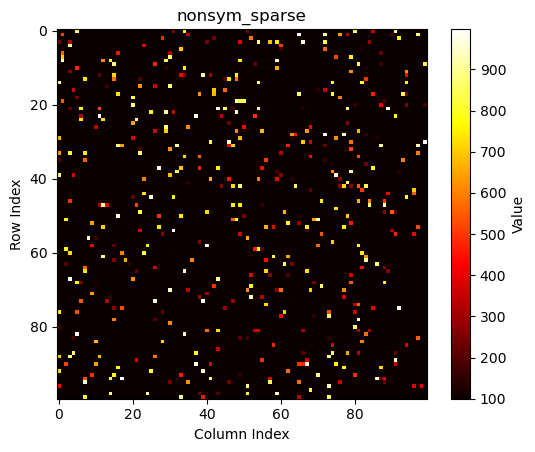

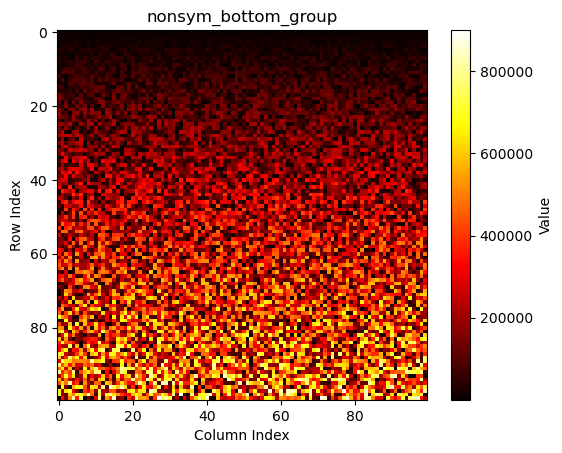

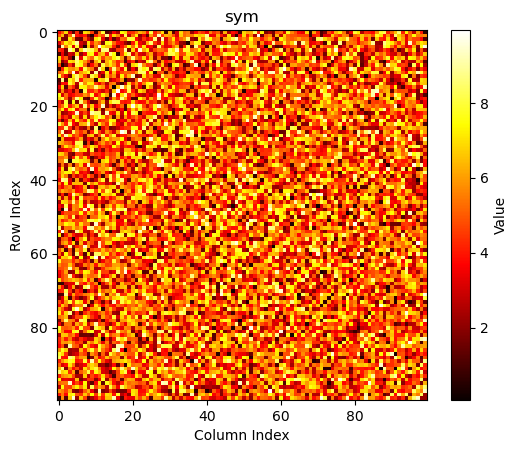

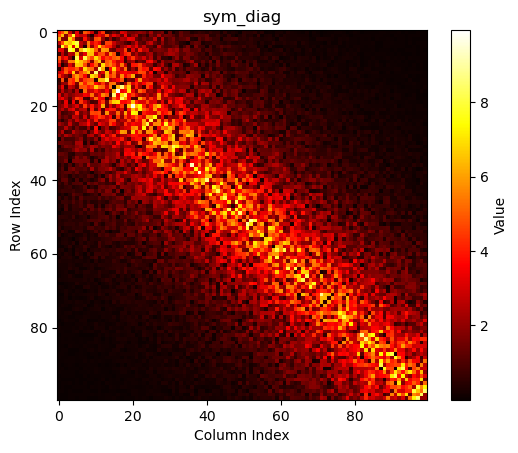

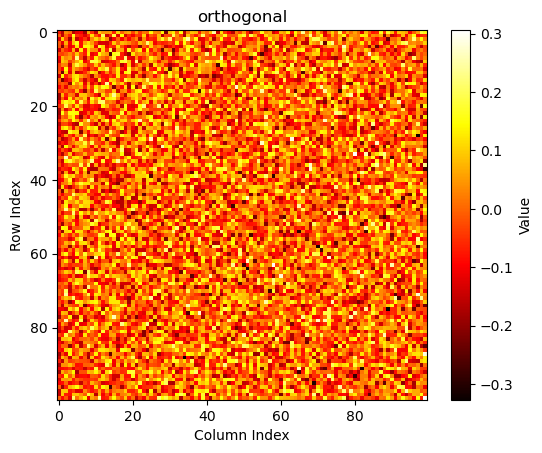

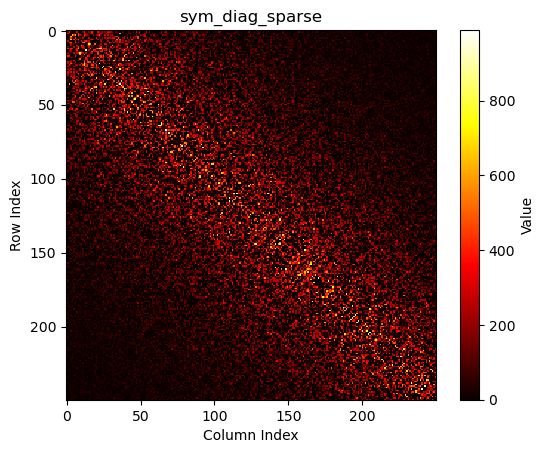

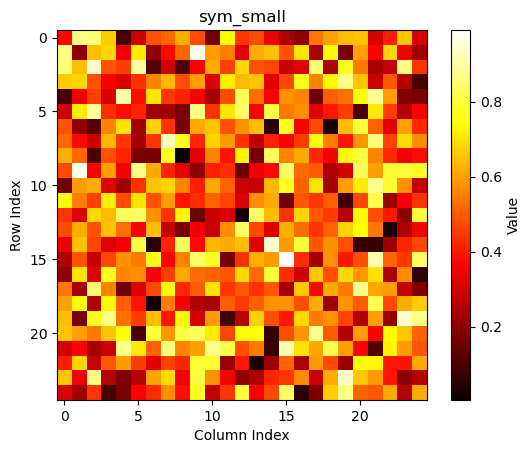

In [7]:
for matrix_id,items in matrix_dict.items():
    name = items[1]
    matrix = items[0]
    plot_2d_temperature(matrix=matrix,title=name)

In [8]:
def qr_householder(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    QR decomposition using Householder reflections.
    """
    m, n = A.shape
    R = A.copy()
    Q = np.eye(m)

    for k in range(min(m - 1, n)):
        x = R[k:, k]
        e1 = np.zeros(len(x))
        e1[0] = 1
        v = x - np.linalg.norm(x) * e1  # Calculate the Householder vector
        H_k = np.eye(m)
        H_k[k:, k:] = np.eye(len(x)) - 2 * np.outer(v, v) / np.dot(v, v) # Embed the reflection 
        Q = Q @ H_k
        R = H_k @ R

    return Q, R



def QR_eigenvalues_algorithm(A : np.array, iteration_number: int = 100) -> np.array:
    A_k = A.copy()
    #plot_2d_temperature(A)
    for k in range(iteration_number):
        Q,R = qr_householder(A_k)
        A_k = R @ Q
    #plot_2d_temperature(A_k)
    #print(np.diag(A_k).shape)
    return np.diag(A_k)
  


----------
nonsym_sparse:
  Time: 4.844848155975342 seconds
NumPy eigvals:
  Time: 0.011600971221923828 seconds

Accuracy:
  Maximum Error: 14232364486317.54
  Average Error: 142323644863.8314
  Median Error: 0.7545105690924474
----------



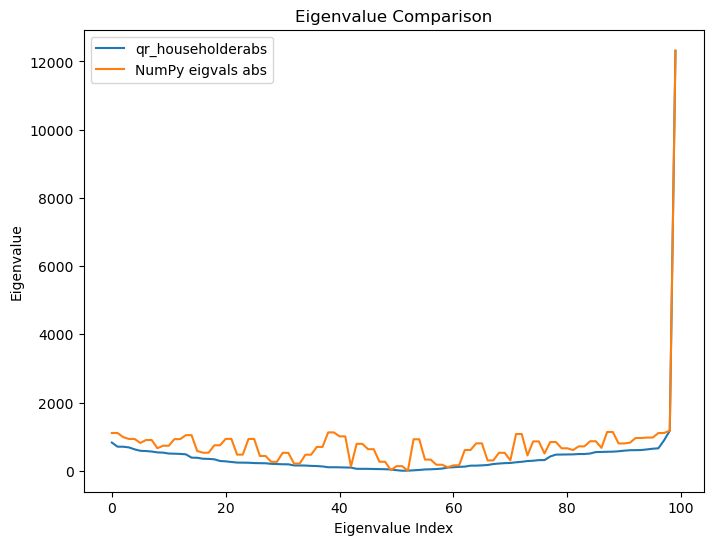

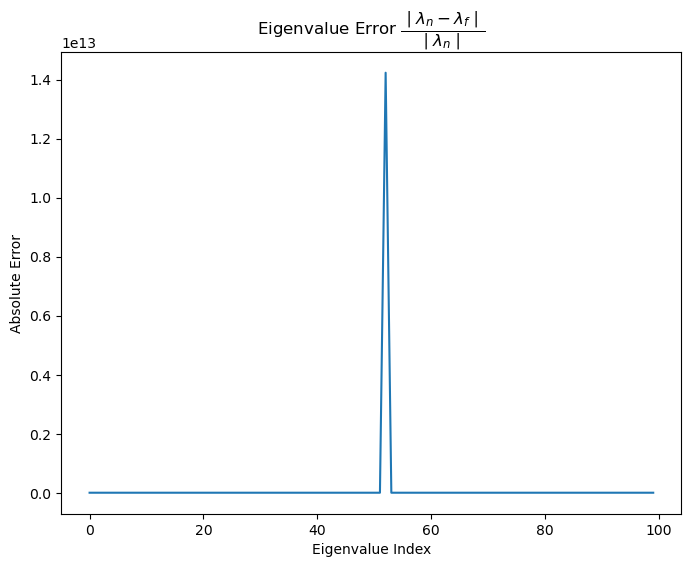

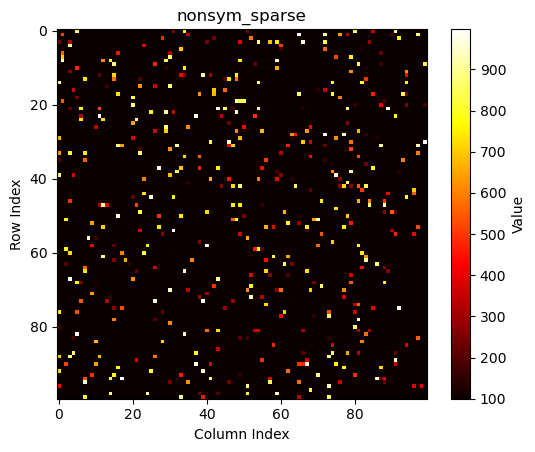

----------
nonsym_bottom_group:
  Time: 3.1739277839660645 seconds
NumPy eigvals:
  Time: 0.0014910697937011719 seconds

Accuracy:
  Maximum Error: 10.040249227185363
  Average Error: 0.7514569204295226
  Median Error: 0.7282977475215446
----------



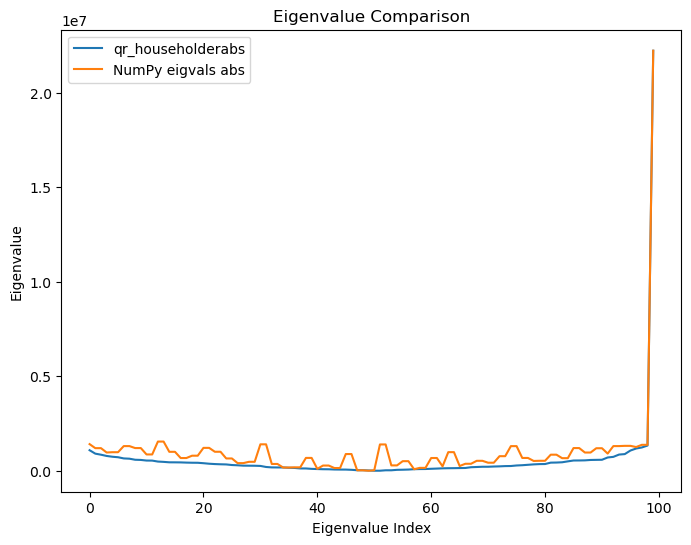

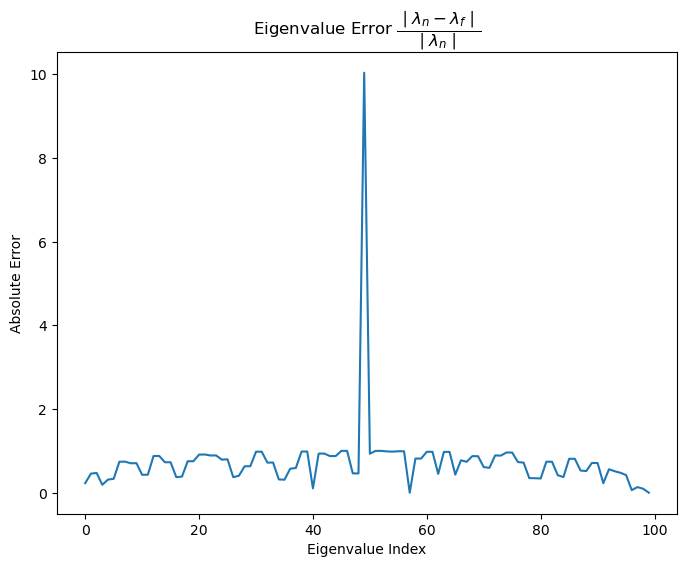

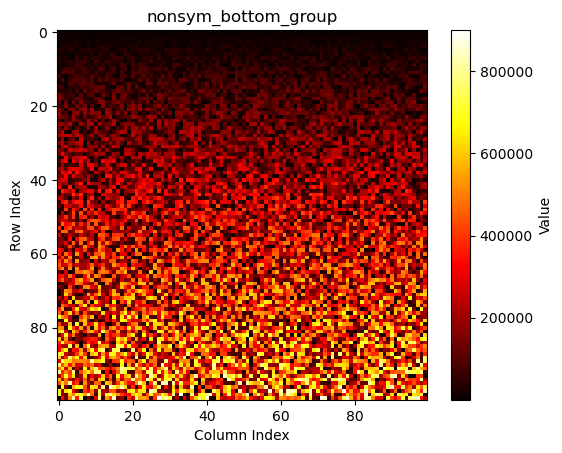

----------
sym:
  Time: 2.7016549110412598 seconds
NumPy eigvals:
  Time: 0.021821022033691406 seconds

Accuracy:
  Maximum Error: 0.4919719938220701
  Average Error: 0.21882980725495188
  Median Error: 0.21861434619263387
----------



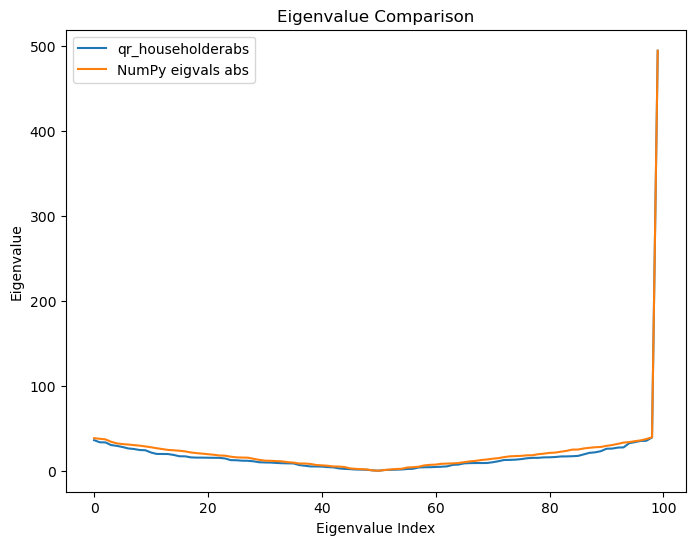

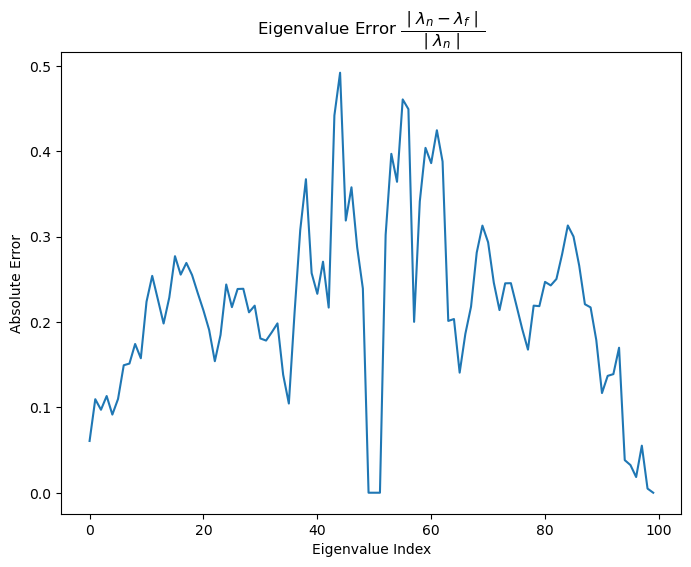

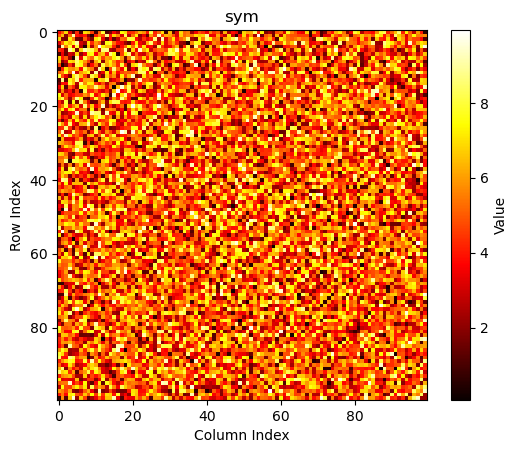

----------
sym_diag:
  Time: 3.9716391563415527 seconds
NumPy eigvals:
  Time: 0.0011057853698730469 seconds

Accuracy:
  Maximum Error: 4.651735780886791
  Average Error: 0.4116201898198712
  Median Error: 0.33049848862427056
----------



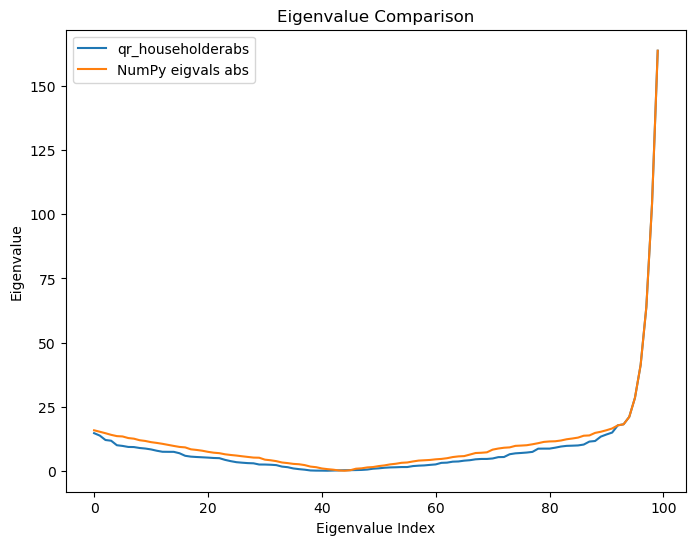

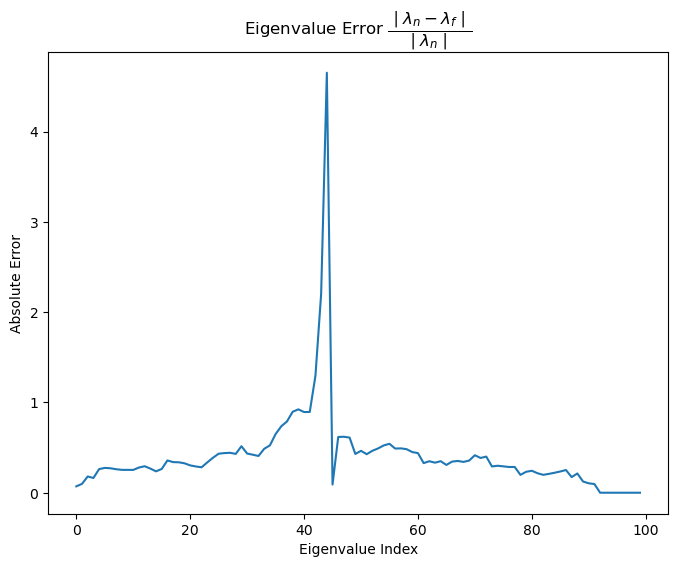

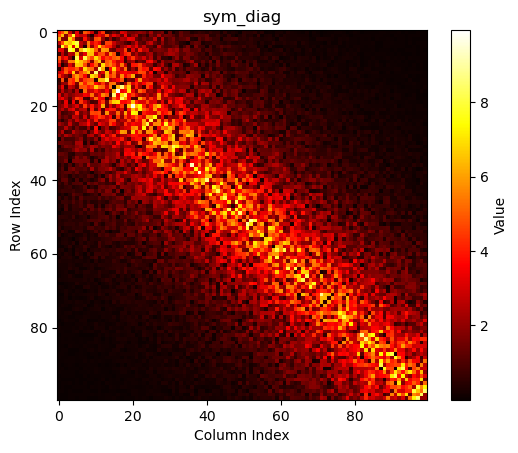

----------
orthogonal:
  Time: 3.462630033493042 seconds
NumPy eigvals:
  Time: 0.0013320446014404297 seconds

Accuracy:
  Maximum Error: 1.0136504865387452
  Average Error: 0.9449417093517762
  Median Error: 0.9690996586796424
----------



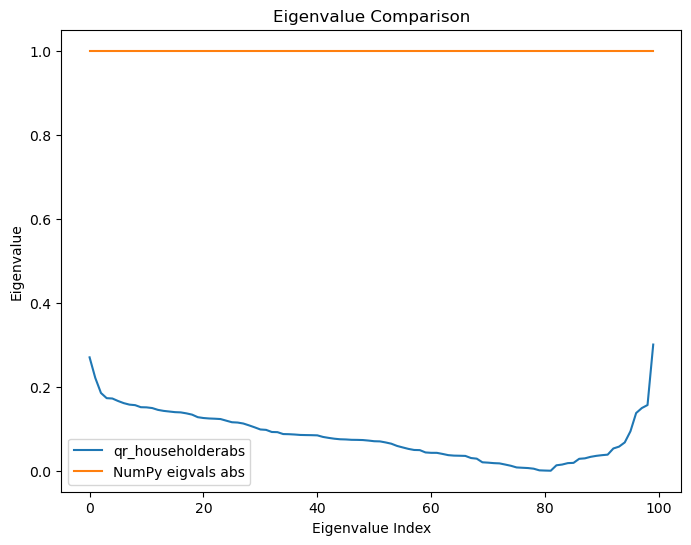

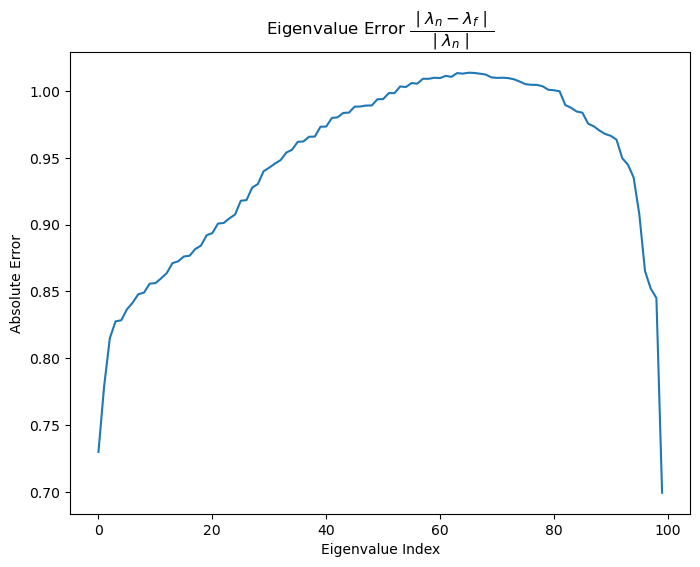

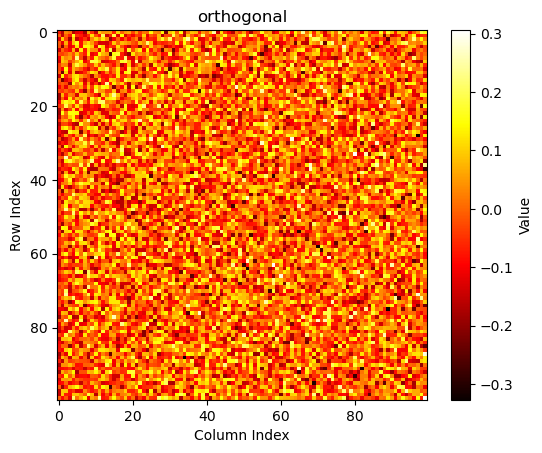

----------
sym_diag_sparse:
  Time: 33.36456799507141 seconds
NumPy eigvals:
  Time: 0.018054962158203125 seconds

Accuracy:
  Maximum Error: 3.7110678144082505
  Average Error: 0.516345297447152
  Median Error: 0.5045819882957745
----------



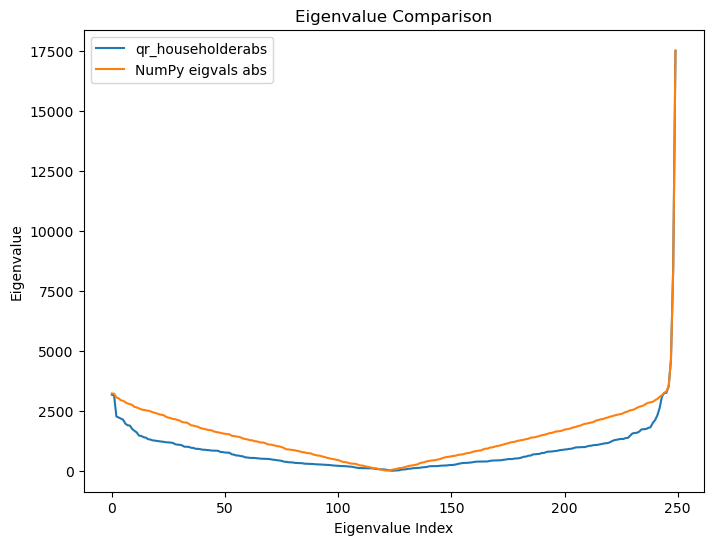

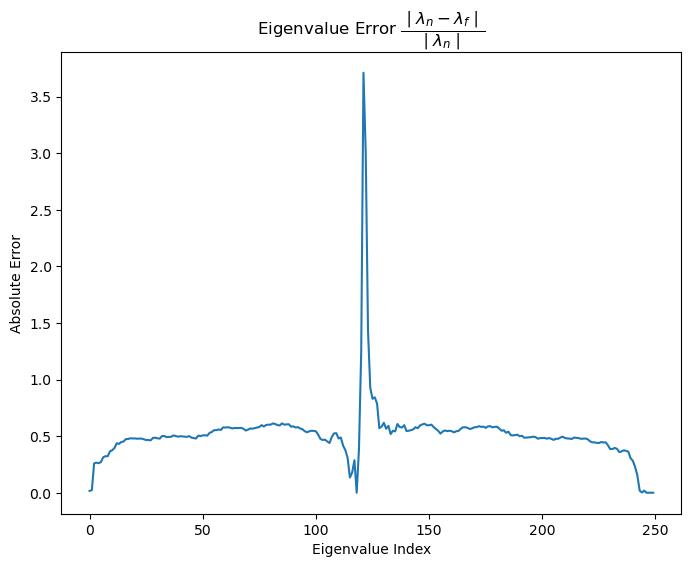

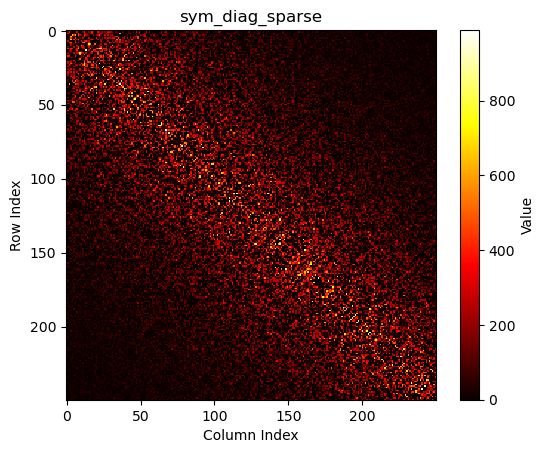

----------
sym_small:
  Time: 0.028191089630126953 seconds
NumPy eigvals:
  Time: 8.606910705566406e-05 seconds

Accuracy:
  Maximum Error: 0.16799445438678415
  Average Error: 0.017332713616339156
  Median Error: 5.670323240916738e-05
----------



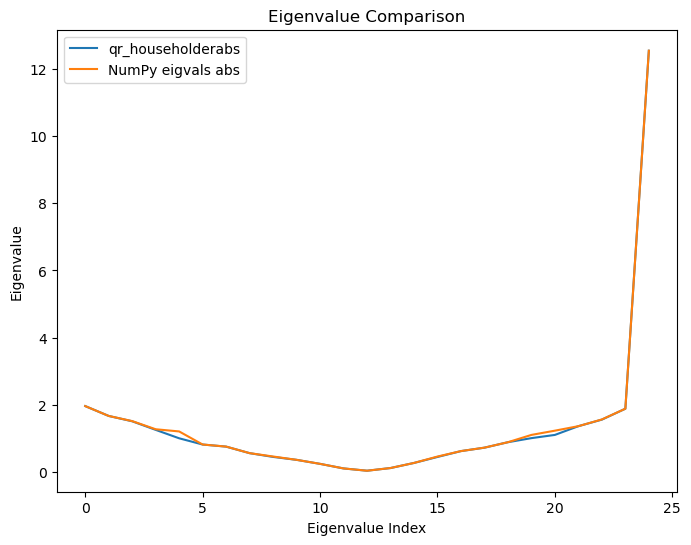

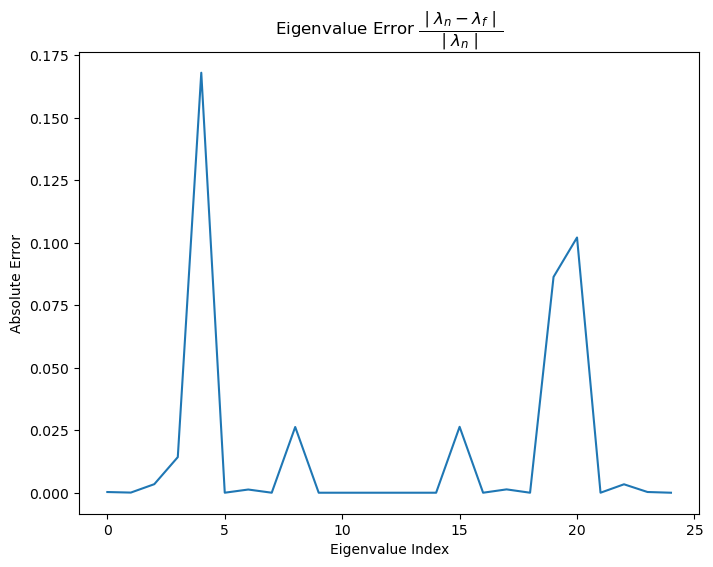

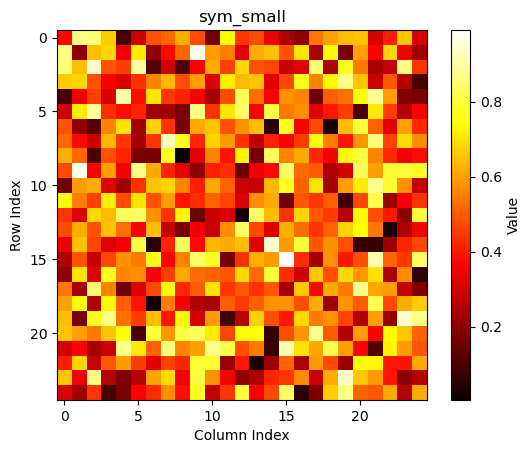

In [9]:
test_all(matrix_dict=matrix_dict,my_function=QR_eigenvalues_algorithm,show_plots=True,skip_matrices_id = [], function_name="qr_householder")